# Кодирование категориальных переменных


In [ ]:
%%capture

!pip install scikit-learn category_encoders -U

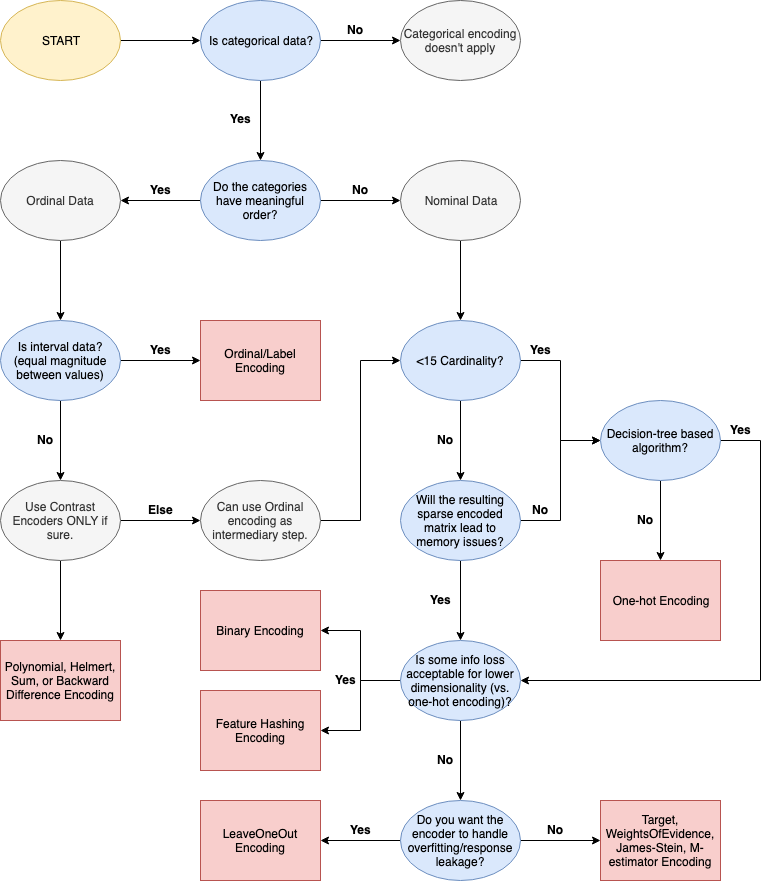

**Порядковые данные (Ordinal)**

Порядковые данные — это когда значения внутри категории упорядочены.

Пример - уровни образования, уровни заработной платы.

**Nominal (номинальные)**

Номинальные данные не имеют порядка, например, города

## Классические подходы

### Label Encoding

При порядковом кодировании каждому строковому значению присваивается целое число, специфичное для этого значения: первое уникальное значение становится 1, второе — 2 и так далее.

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

In [ ]:
education = ['School', 'College', 'University']

In [ ]:
le = LabelEncoder()
le.fit(education)
list(le.classes_)

['College', 'School', 'University']

In [ ]:
le.transform(["College", "School", "College"])

array([0, 1, 0])

In [ ]:
list(le.inverse_transform([2, 2, 1]))

['University', 'University', 'School']

### Ordinal Encoding

In [ ]:
oe = OrdinalEncoder(categories=[education])
oe.fit_transform(np.array(['School', 'College']).reshape(-1, 1))

array([[0.],
       [1.]])

In [ ]:
list(oe.categories_)

[array(['School', 'College', 'University'], dtype=object)]

Порядковое кодирование может быть полезно для кодирования **интервальных данных**.

Однако, если значения данных не следуют возрастающему порядку, использовать такой способ кодирования не рекомендуется. Алгоритмы машинного обучения не могут различать категориальные и числовые данные и, следовательно, будут определять порядок, который может быть неправильным.

### OneHot/Dummy Encoding


One-hot encoding работает путем создания нового столбца для каждого значения. Каждому новому столбцу присваивается 1, если строка содержит значение этого столбца, и 0 в противном случае.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
X = [['Male'], ['Female'], ['Female']]
enc.fit(X)
enc.categories_

[array(['Female', 'Male'], dtype=object)]

In [ ]:
enc.transform([['Female'], ['Male']]).toarray()

array([[1., 0.],
       [0., 1.]])

In [ ]:
enc.get_feature_names_out(['gender'])

array(['gender_Female', 'gender_Male'], dtype=object)

OHE обычно работает хорошо, однако имеет существенный недостаток: количество создаваемых признаков равно количеству уникальных значений, что приводит к серьезным проблемам с памятью при работе с наборами данных с высокой кардинальностью.

Существуют также проблемы с OHE, когда речь идет о [decision-tree based алгоритмах](https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/).

### Binary Encoding

Binary encoding служит промежуточным звеном между горячим кодированием и порядковым кодированием — оно уменьшает неявное смещение порядка LE, создавая при этом меньше столбцов, чем OHE.

В binary encoding  значения категорий сначала закодированы в лексикографическом порядке. Полученные целые числа преобразуются в двоичные, а затем полученные цифры разбиваются на столбцы.

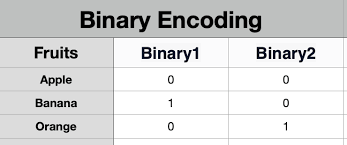

In [ ]:
import category_encoders as ce

In [ ]:
encoder = ce.BinaryEncoder()
encoder.fit(["paris", "paris", "tokyo", "amsterdam"])

BinaryEncoder(cols=[0],
              mapping=[{'col': 0,
                        'mapping':     0_0  0_1
 1    0    1
 2    1    0
 3    1    1
-1    0    0
-2    0    0}])

In [ ]:
encoder.get_feature_names_out()

array(['0_0', '0_1'], dtype=object)

In [ ]:
encoder.transform(["paris", "paris", "tokyo", "amsterdam"])

,0_0,0_1
0,0,1
1,0,1
2,1,0
3,1,1


Binary encoding может подразумевать упорядочение, которое может быть как полезным, так и вредным или незначительным для работы модели в зависимости от ситуации.

Если OHE вызывает серьезные проблемы с памятью, Binary encoding может служить простой и эффективной альтернативой, которая может уменьшить проблему.

### Hashing Encoding

Hashing Encoding также служит альтернативой OHE с меньшей размерностью. В  этом кодировщике используется [hashing trick](https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f).

В Hashing Encoding используют алгоритм хеширования для сопоставления значений категорий с числовыми значениями, которые затем соответствующим образом разбиваются на столбцы.

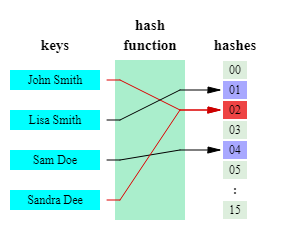

In [ ]:
encoder = ce.HashingEncoder()
encoder.fit(["paris", "paris", "tokyo", "amsterdam"])

HashingEncoder(cols=[0], max_process=1)

In [ ]:
encoder.get_feature_names_out()

array(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6',
       'col_7'], dtype=object)

In [ ]:
encoder.transform(["paris", "paris", "tokyo", "amsterdam"])

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0


In [ ]:
encoder = ce.HashingEncoder(n_components=4)
encoder.fit_transform(["paris", "paris", "tokyo", "amsterdam", "moscow", "london"])

,col_0,col_1,col_2,col_3
0,1,0,0,0
1,1,0,0,0
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0
5,0,0,0,1


Количество создаваемых столбцов является параметром и может быть установлено меньше количества уникальных значений, что означает меньшее общее количество столбцов, чем при OHE.

Hashing Encoding не поддерживает словарь категорий -> кодировщик не увеличивается в размерах и умеет обрабатывать новые категории.

В целом, Hashing Encoding — еще одна жизнеспособная альтернатива в случае, если OHE приводит к проблемам с размерностью.

## Bayesian Encoders

Bayesian Encoders отличаются от классических кодировщиков тем, что они также используют информацию из целевой переменной. Они производят только один столбец на выходе.

### Target Encoding

Target Encoding заменяет каждое конкретное значение категории средневзвешенным значением зависимой переменной.

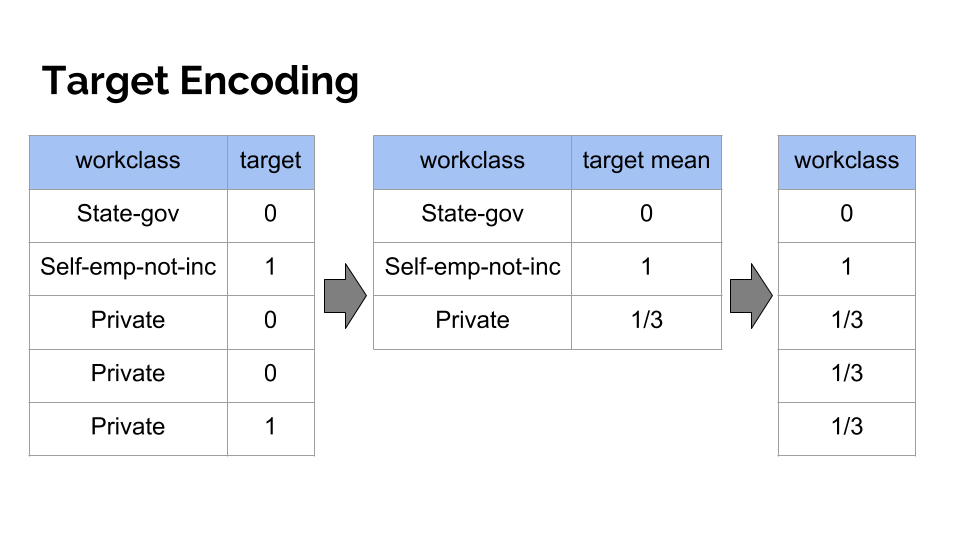

In [ ]:
import pandas as pd
from sklearn.preprocessing import TargetEncoder

In [ ]:
y.shape

(88,)

In [ ]:
X = np.array(["dog"] * 20 + ["cat"] * 30 + ["snake"] * 38, dtype=object).T
y = np.array([90.3] * 5 + [80.1] * 15 + [20.4] * 5 + [20.1] * 25 + [21.2] * 8 + [49] * 30)

pd.DataFrame([X, y]).T.sample(10, random_state=77)

,0,1
43,cat,20.1
62,snake,49.0
55,snake,21.2
80,snake,49.0
45,cat,20.1
12,dog,80.1
71,snake,49.0
63,snake,49.0
8,dog,80.1
5,dog,80.1


In [ ]:
enc = TargetEncoder(smooth="auto").fit(X.reshape(-1, 1), y)
enc.encodings_

[array([20.15001694, 82.58705994, 43.15381172])]

In [ ]:
enc.categories_

[array(['cat', 'dog', 'snake'], dtype=object)]

In [ ]:
enc.transform([['mouse']])

array([[44.28522727]])

Основная проблема с целевым кодированием — утечка целевой переменной.

Однако при небольшой корректировке эти опасения можно облегчить.

### LeaveOneOut Encoding

Кодировка LeaveOneOut идентична TargetEncoding, за исключением того, что она решает проблемы Target Encoding с утечкой ответа.

В кодировке LeaveOneOut рассматриваемая строка не учитывает собственное значение при вычислении среднего значения.

Каждая строка имеет разное значение, поскольку она не включает свое собственное значение при вычислении среднего значения. Это уменьшает утечку, и при более значительном количестве строк вычисленное среднее значение не должно сильно различаться от категории к категории.

У кодирования LeaveOneOut нет реальных недостатков, но имейте в виду, что данные обучения/тестирования необходимо разделить перед обработкой. В противном случае информация из тестовых данных попадет в обучающие данные.

### Ordered Target Encoding

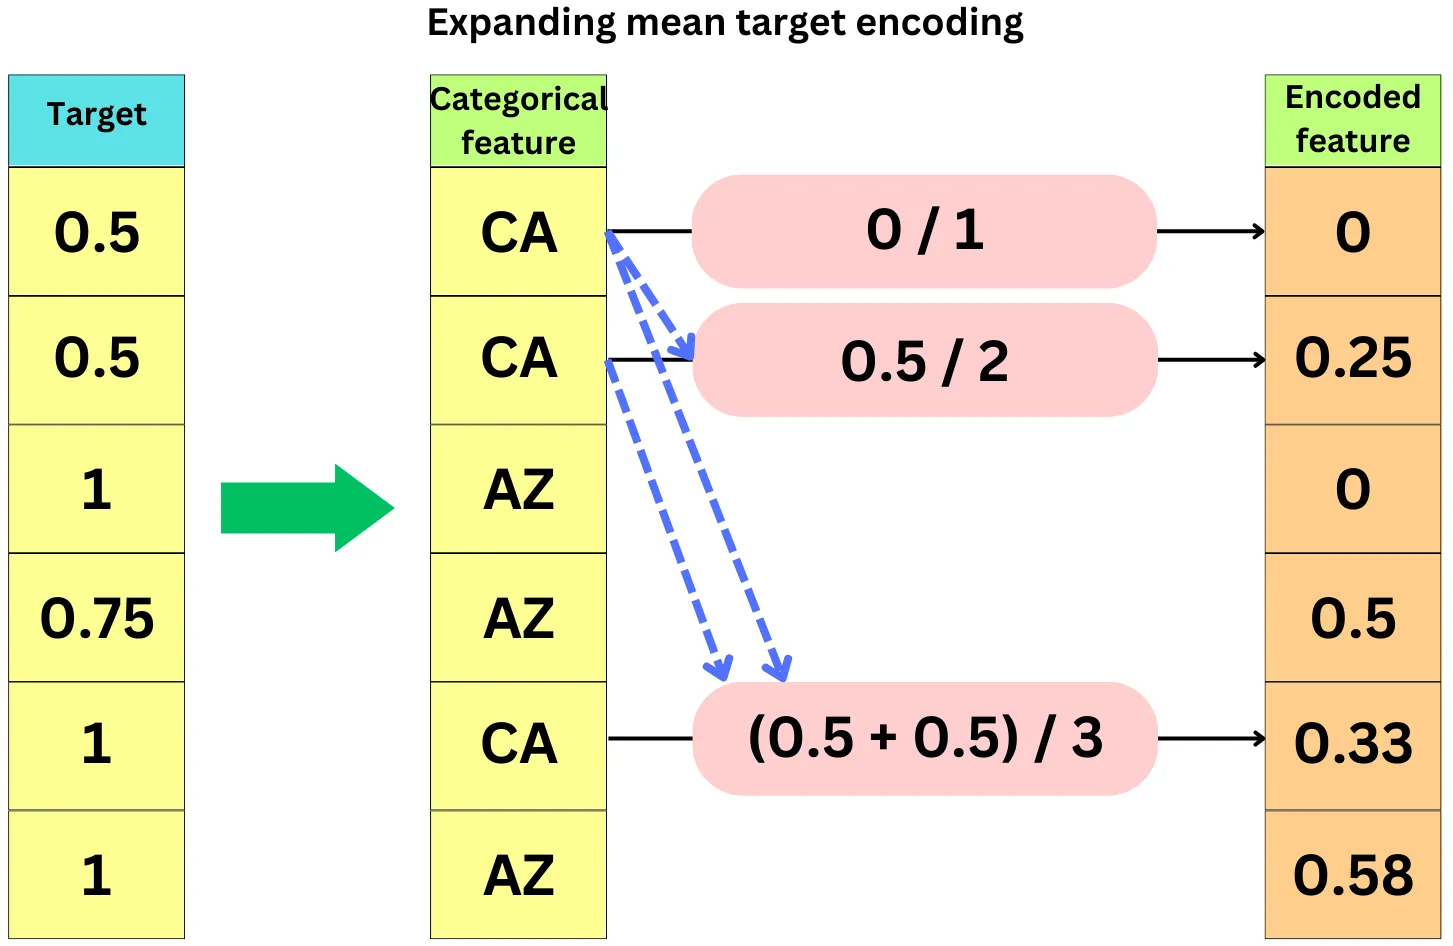